In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functions as fnc
import os
import sys
import glob
import cv2

In [25]:
para={'OutDIR': '/DATA/vito/output/Ravi2_run2_dw1_cp1024_pps48/',
      'DataDIR': '/DATA/vito/data/',
      #'DatasetName': 'sand/*',
      'DatasetName': 'Ravi/*',
      #'DatasetName': 'example/*',
      'fid': None,
      'crop_size': 1024,
      'resample_factor': 1,
      'point_per_side': 48,
      'dilation_size':15,
      'min_size_factor':0.0001,
      #'window_step':0.5,
      'b':200
      }

if para.get('fid')==None:
    if not os.path.exists(para.get('DataDIR')+para.get('DatasetName')[:-1]):
        print('Input directory does not exist. Exiting script.')
        sys.exit()
    fn_img = glob.glob(para.get('DataDIR')+para.get('DatasetName'))
    fn_img.sort()
    for i,fn in enumerate(fn_img):
        print(i, ': ', fn)
    print('--------------')
    while True:
        try:
            user_input = int(input("Please select an image: "))
            print(f"{fn_img[user_input]} selected")
            para.update({'fid':user_input})
            break  # Exit the loop if the input is valid
        except ValueError:
            print("Requires an index. Please try again.")
resample_factor=para.get('resample_factor')
DataDIR=para.get('DataDIR')
DSname=para.get('DatasetName')
fid=para.get('fid')

image=fnc.load_image(DataDIR,DSname,fid)
print(image.shape)

0 :  /DATA/vito/data/Ravi/Ravi2_orthomosaic_02mm.png
1 :  /DATA/vito/data/Ravi/Ravi3_DEM_clip_07mm_segment_ids.npy
2 :  /DATA/vito/data/Ravi/Ravi3_DEM_clip_07mm_segment_vis.npy
3 :  /DATA/vito/data/Ravi/Ravi3_orthomosaic_clip_02mm.tif
4 :  /DATA/vito/data/Ravi/Ravi4_orthomosaic_clip_02mm.tif
5 :  /DATA/vito/data/Ravi/label
--------------
/DATA/vito/data/Ravi/Ravi3_orthomosaic_clip_02mm.tif selected
Ravi3_orthomosaic_clip_02mm.tif imported
(28382, 32563, 3)


In [30]:
pre_para={'Resample': {'fxy':1/4}}
prep_image=fnc.preprocessing_roulette(image, pre_para)

In [31]:
prep_image=prep_image[2000:5000,2000:5000,:3]

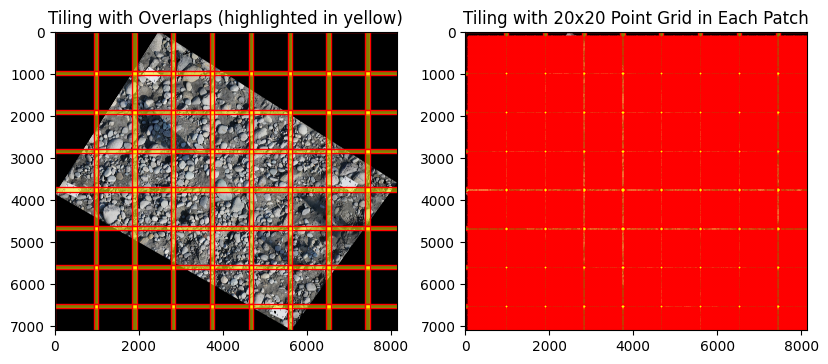

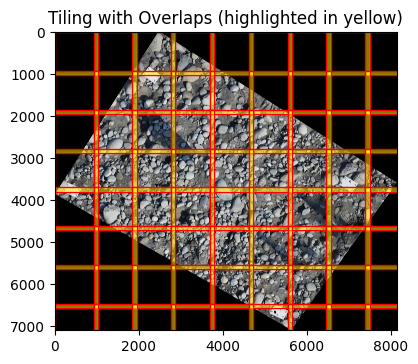

In [27]:
crop_size = 1024
overlap = 100
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
fnc.plot_tiling_with_overlap(prep_image, (crop_size,crop_size), overlap)
plt.subplot(1,3,2)
fnc.plot_grid_in_patches(prep_image, (crop_size,crop_size), overlap, 20)
crop_size = 1024
overlap = 100
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
fnc.plot_tiling_with_overlap(prep_image, (crop_size,crop_size), overlap)

Text(0.5, 1.0, 'Tiling into 1024 x 1024 patches\nWindow overlap (yellow) = 200 pixels')

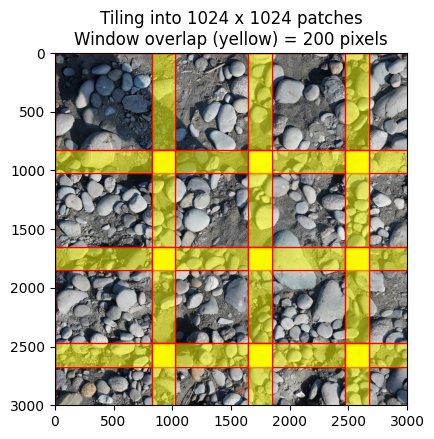

In [32]:
crop_size = 1024
overlap = 200
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
fnc.plot_tiling_with_overlap(prep_image, (crop_size,crop_size), overlap)
plt.title('Tiling into 1024 x 1024 patches\nWindow overlap (yellow) = 200 pixels')


In [315]:
import First_second_fnc as FS_fnc
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGenerator
import gc
import torch
image=prep_image
pps=30
b=100
stb_t=0.85
#defining clips
crop_size=1024
resample_factor=1
min_pixel=0
min_radi=0
dic_list=[]
patches = fnc.get_image_patches(image, crop_size, 2*b)
print(f'Tiled into {len(patches)} patches')
patch_keys=patches.keys()
max_ij=np.max(np.array(list(patch_keys)),axis=0)
#setup SAM
MODEL_TYPE = "vit_h"
DEVICE, CHECKPOINT_PATH=fnc.set_sam(MODEL_TYPE,DataDIR)

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

ij_idx=(2,1)
print(f'Segmenting clip: {ij_idx}')
#prepare image
temp_image=patches[ij_idx]
if (temp_image.shape[0]>(crop_size//4) and temp_image.shape[1]>(crop_size//4)):
    if len(np.unique(temp_image))>1:
        #clear gpu ram
        gc.collect()
        torch.cuda.empty_cache()

        #SAM segmentation
        mask_generator = SamAutomaticMaskGenerator(
            model=sam,
            points_per_side=pps,
            pred_iou_thresh=0,
            stability_score_thresh=stb_t,#iou by varying cutoff in binary conversion
            box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
            crop_n_layers=0,#cut into 2**n crops
            crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
            crop_n_points_downscale_factor=1,
            crop_overlap_ratio=0,
        )
        predictor = SamPredictor(sam)
        predictor.set_image(temp_image)

        with torch.no_grad():
            masks = mask_generator.generate(temp_image)
        print('First pass SAM: ', len(masks),' mask(s) found')

        #post processing
        #filter output mask per point by select highest pred iou mask
        masks=FS_fnc.filter_by_pred_iou_and_size_per_seedpoint(masks, crop_size)
        print('Filtered by highest predicted iou per seed point, ', len(masks),' mask(s) remains')

        list_of_pred_iou = [mask['predicted_iou'] for mask in masks]
        list_of_masks = [fnc.clean_mask(mask['segmentation'].astype('bool')) for mask in masks]#remove small disconnected parts
        no_area_after_cleaning=np.array([np.sum(mask)==0 for mask in list_of_masks])
        area_radi=np.array([fnc.area_radi(mask, min_pixel, min_radi) for mask in list_of_masks])
        if np.any(no_area_after_cleaning):
            list_of_masks = [mask for mask, keep in zip(list_of_masks, ~no_area_after_cleaning) if keep]
            list_of_pred_iou = [iou for iou, keep in zip(list_of_pred_iou, ~no_area_after_cleaning) if keep]
        if not np.all(area_radi):
            list_of_masks = [mask for mask, keep in zip(list_of_masks, area_radi) if keep]
            list_of_pred_iou = [iou for iou, keep in zip(list_of_pred_iou, area_radi) if keep]
        #remove background/edge mask
        flattened_rgb=np.sum(temp_image,axis=2)
        not_background_mask=np.array([np.any(flattened_rgb[mask.astype('bool')]>0) for mask in list_of_masks])
        if not np.all(not_background_mask):
            list_of_masks = [mask for mask, keep in zip(list_of_masks, not_background_mask) if keep]
            list_of_pred_iou = [mask for mask, keep in zip(list_of_pred_iou, not_background_mask) if keep]
            print('Background masks removed')
        
        if len(list_of_masks)>0:
            #grouping overlaps
            list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms=[],[]
            group_overlap_area, unique_groups, list_overlap = FS_fnc.Groupping_masks(list_of_masks)
            unique_groups_thresholded = FS_fnc.filter_groupping_by_intersection(group_overlap_area,unique_groups, list_overlap)#intersection
            cleaned_groups, list_of_nooverlap_mask = FS_fnc.checking_remaining_ungroupped(list_of_masks, unique_groups_thresholded, masks)
            if cleaned_groups:
                list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score = FS_fnc.Guided_second_pass_SAM(cleaned_groups, min_pixel, min_radi, list_of_masks, predictor, crop_size)
                if len(list_of_nooverlap_mask)>0:
                    for m in list_of_nooverlap_mask:
                        list_of_cleaned_groups_reseg_masks.append(list_of_masks[m].astype('bool'))
                        list_of_cleaned_groups_reseg_score.append(list_of_pred_iou[m])
                list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms = fnc.nms(list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score)
                print('Found ',len(list_of_cleaned_groups_reseg_score_nms), ' mask(s)/object(s) in the clip')
            else:
                list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score = list_of_masks, list_of_pred_iou
                list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms = fnc.nms(list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score)
                print(f'No groups were found, found {len(list_of_cleaned_groups_reseg_masks)} mask(s) from the first pass')
                print(f'{len(list_of_cleaned_groups_reseg_masks_nms)} left after nms filtering')

            #valid box
            if len(list_of_cleaned_groups_reseg_masks_nms)>0:
                keep = FS_fnc.mask_in_valid_box(list_of_cleaned_groups_reseg_masks_nms,b, ij_idx, max_ij)
                discarded=[list_of_cleaned_groups_reseg_masks_nms[i] for i,k in enumerate(keep) if not k]
                list_of_cleaned_groups_reseg_masks_nms=[list_of_cleaned_groups_reseg_masks_nms[i] for i,k in enumerate(keep) if k]
                

                    
                    #np.save(OutDIR+f'chunks/chunk_{int(ij_idx[0])}_{int(ij_idx[1])}',[msk_dic])
                    #del msk_dic, list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms
            else:
                print('No valid mask were found')
        else:
            print('No valid mask were found')
    else:
        print('This crop is bacground/edge')
else:
    print('This crop is too small')            

Tiled into 16 patches
Currently running on GPU
Model vit_h


Segmenting clip: (2, 1)
First pass SAM:  1806  mask(s) found
Filtered by highest predicted iou per seed point,  808  mask(s) remains
Threshold: 1000 pixels, 571023 groups removed 
Overlap groups before filtering: 571113, after filtering: 90
Found  375  mask(s)/object(s) in the clip


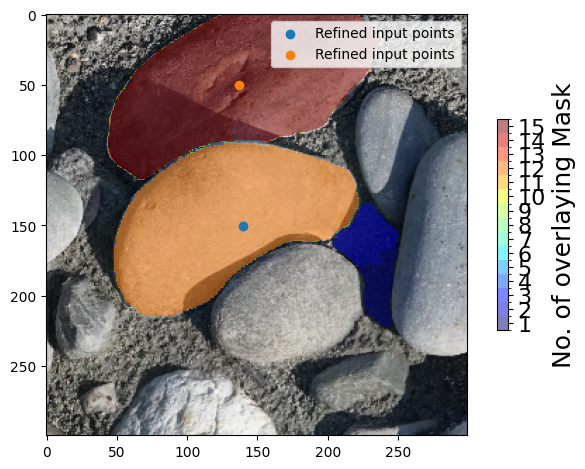

In [244]:
from skimage.measure import label, regionprops
plt.imshow(temp_image[0:300,400:700])
fnc.show_mask_stack(np.sum([list_of_masks[i] for i in cleaned_groups[3]], axis=0)[0:300,400:700], plt.gca())
stacked=np.stack([list_of_masks[i] for i in cleaned_groups[3]])
mean_stacked=np.mean(stacked,axis=0)
#std_stacked=np.std(stacked,axis=0)

#separate high confidence region(high mean) and low
labels=label(np.logical_and(mean_stacked<=0.5,mean_stacked>0))
regions=regionprops(labels)
labels=label(np.logical_and(mean_stacked>0.5,mean_stacked>0))
regions_highmean=regionprops(labels)
for region in regions_highmean:
    regions.append(region) 

for props in regions:
    if (props.area>100):#apply minimum area to filter out mini residuals
        y0, x0 = props.centroid
        input_point = np.array([[x0,y0]])
        plt.scatter(x0-400,y0, label='Refined input points')
plt.legend()
plt.tight_layout()

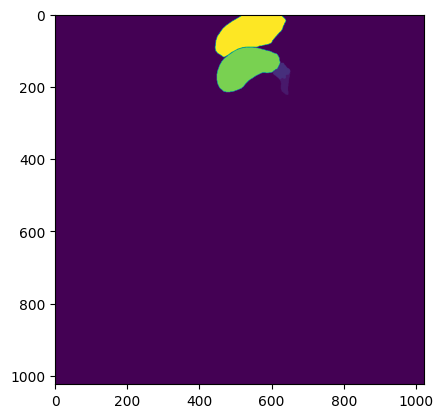

In [234]:
plt.imshow(np.sum([list_of_masks[i] for i in cleaned_groups[3]], axis=0))

In [52]:
patch11_keep=np.sum(list_of_cleaned_groups_reseg_masks_nms, axis=0)>0
patch11_discard=np.sum(discarded, axis=0)>0

In [55]:
patch21_keep=np.sum(list_of_cleaned_groups_reseg_masks_nms, axis=0)>0
patch21_discard=np.sum(discarded, axis=0)>0

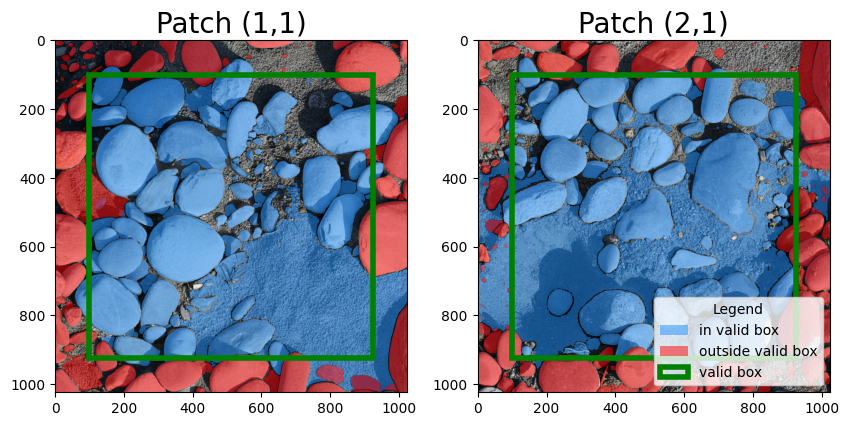

In [68]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(patches[(1,1)])
fnc.show_mask(patch11_keep,plt.gca())
fnc.show_mask(patch11_discard,plt.gca(),np.array([255/255, 1/255, 1/255]))
box_size=824
start = (1024 - box_size) // 2  # = 100

from matplotlib.patches import Patch, Rectangle
rect = Rectangle(
    (start, start), box_size, box_size,
    linewidth=4, edgecolor='green', facecolor='none'
)
ax=plt.gca()
ax.add_patch(rect)
plt.title('Patch (1,1)', fontsize=20)
plt.subplot(1,2,2)
plt.imshow(patches[(2,1)])
fnc.show_mask(patch21_keep,plt.gca())
fnc.show_mask(patch21_discard,plt.gca(),np.array([255/255, 1/255, 1/255]))
plt.title('Patch (2,1)', fontsize=20)
rect2 = Rectangle(
    (start, start), box_size, box_size,
    linewidth=4, edgecolor='green', facecolor='none'
)
ax2=plt.gca()
ax2.add_patch(rect2)


color_inside = np.array([30/255, 144/255, 255/255, 0.5])  # DodgerBlue with alpha
color_outside = np.array([255/255, 1/255, 1/255, 0.5])    # Bright Red with alpha

legend_handles = [
    Patch(facecolor=color_inside, edgecolor='none', label='in valid box'),
    Patch(facecolor=color_outside, edgecolor='none', label='outside valid box'),
    Rectangle((0, 0), 1, 1, edgecolor='green', facecolor='none', linewidth=4, label='valid box')
]

plt.legend(handles=legend_handles, loc='lower right', title='Legend')

In [316]:
list_of_cleaned_groups_reseg_masks_nms=[list_of_cleaned_groups_reseg_masks_nms[i] for i in range(len(list_of_cleaned_groups_reseg_masks_nms)) if np.sum(list_of_cleaned_groups_reseg_masks_nms[i])/(1024*1024)<0.2]

In [317]:
patch21_keep=np.sum(list_of_cleaned_groups_reseg_masks_nms, axis=0)>0

In [318]:
id_mask=np.zeros_like(patch21_keep).astype(np.uint16)
for i in range(len(list_of_cleaned_groups_reseg_masks_nms)):
    id_mask+= (list_of_cleaned_groups_reseg_masks_nms[i]*(i+1)).astype(np.uint16)

In [319]:
label_img = label(id_mask)
regions = regionprops(label_img)

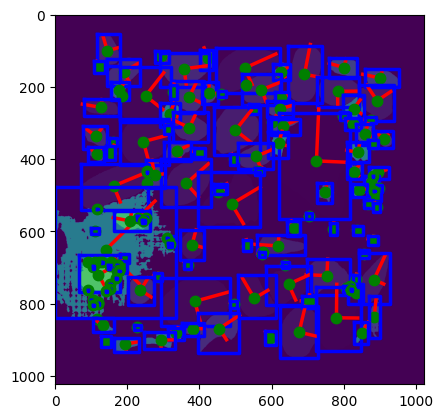

In [313]:
plt.imshow(id_mask)
ax=plt.gca()
import math
from skimage.measure import label, regionprops

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

(3000, 3000, 3)


Text(0.5, 1.0, 'Measuring a- and b-axis')

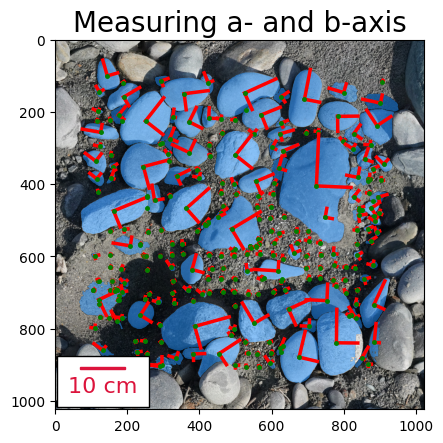

In [324]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
resolution = 0.2*4
scalebar_length_mm = 100  
scalebar_length_px = scalebar_length_mm / resolution
plt.imshow(patches[(2,1)])
fnc.show_mask(patch21_keep,plt.gca())
ax=plt.gca()
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=5)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    #ax.plot(bx, by, '-b', linewidth=2.5)

scalebar = AnchoredSizeBar(ax.transData, scalebar_length_px, '10 cm', 
                           loc='lower left', pad=0.5, sep=5, 
                           color='crimson', frameon=True, size_vertical=5,
                           fontproperties=fm.FontProperties(size=16))
print(image.shape)
ax.add_artist(scalebar)
plt.title('Measuring a- and b-axis', fontsize=20)

In [ ]:
min_size_of_interest = 100 #in mm2
detection_limit = 200/(0.2*0.2) #in pixels
resolution = 0.2 #in mm
resampling = 1 #if any inteded


required_resolution_for_min_size = np.sqrt((min_size_of_interest*resampling**2)/detection_limit)
print(f"Required resolution for {min_size_of_interest} mm2 is {required_resolution_for_min_size} mm")

In [ ]:
temp=np.arange(1,11,1)
resolution= np.concatenate((temp/10, temp[:-5]))

detection_limit = np.pi*(12)**2#in pixels
min_detectable_size_at_resolution = detection_limit*(resolution**2)

In [ ]:
from numba import njit

@njit
def generate_centroid_positions(window_size):
    positions = []
    for x in range(window_size):
        for y in range(window_size):
            positions.append((x, y))
    return np.array(positions)

@njit
def calculate_percentage_within_window(window_size, circle_radius, centroid_positions):
    circle_area = np.pi * (circle_radius ** 2)
    percentage_within_window = []
    
    for circle_center in centroid_positions:
        cx, cy = circle_center
        window_circle_area = 0
        
        for x in range(window_size):
            for y in range(window_size):
                dist_sq = (x - cx) ** 2 + (y - cy) ** 2
                if dist_sq <= circle_radius ** 2:
                    window_circle_area += 1
        
        percentage_within_window.append(window_circle_area / circle_area)
    
    return np.array(percentage_within_window)

@njit
def calculate_probabilities(image_size, buffer, radii):
    window_size = image_size - 2 * buffer
    centroid_positions = generate_centroid_positions(window_size)
    
    radi_list = []
    percentage_list = []
    
    for circle_radius in radii:
        percentage_within_window = calculate_percentage_within_window(
            window_size, circle_radius, centroid_positions
        )
        radi_list.append(percentage_within_window)
        percentage_list.append(np.sum(percentage_within_window > 0.5) / (image_size ** 2))
    
    return radi_list, percentage_list

# Define parameters
image_size = 1024
buffer = 100
window_size = image_size - 2*buffer
radii = [100, 150, 200, 250, 300, 350, 400, 450, 500]

# Run the calculation
radi_list, percentage_list = calculate_probabilities(image_size, buffer, radii)

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(2,2,1)
plt.plot(resolution, min_detectable_size_at_resolution)
plt.grid()
plt.xlabel('Resolution (mm)') 
plt.ylabel('Size (mm2)')
plt.title('Minimum detectable size at different resolutions')

plt.subplot(2,2,3)
plt.plot(radii,[np.sum(lst>0.5)/(window_size** 2) for lst in radi_list],label='Only considering fully captured circles')
plt.plot(radii, percentage_list, label='Also consider partially captured circles')
plt.grid()
plt.xlabel('Circle radius (pixels)')
plt.ylabel('Probability')
plt.title('Probability of at least half the circle\nlanding within the window(buffer = 100 pixels)')
plt.legend()

# the size of valid box caps the maximum probablilty of valid detection 
# because centroid must land within the box to have the chance that 50% of the circle is within the box
plt.subplot(1,2,2)
max_prob_list = [((image_size - 2*b)**2)/(image_size**2) for b in range(image_size//2)]

plt.plot(range(image_size//2), max_prob_list)
plt.grid()
plt.xlabel('Buffer size (pixels)')
plt.ylabel('Maximum probability')
plt.title('Maximum probability of valid detection at different buffer sizes\nassuming max radius of interest equals to buffer size')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()
